# Crecimiento monetario

Este notebook tiene los siguientes objetivos:
- Mostrar las diferencias en el crecimiento de la cantidad de dinero en diferentes economías.
- Establecer una relación entre crecimiento de la cantidad de dinero, la velocidad del dinero y la inflación.

Se estudiarán las siguientes áreas monetarias: los Estados Unidos, la Eurozona, Suiza, el Reino Unido y Japón.

In [220]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

from importlib import reload
import utils
reload(utils)
from utils import get_snb_data, get_ecb_data, get_boe_data

load_dotenv()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

## Recesiones

Datos obtenidoss de NBER: [US Business Cycle Expansions and Contractions](https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions).

In [221]:
df_recessions = pd.DataFrame([
    [pd.Timestamp('1857-04-01'), pd.Timestamp('1858-10-01')],
    [pd.Timestamp('1860-07-01'), pd.Timestamp('1861-07-01')],
    [pd.Timestamp('1865-01-01'), pd.Timestamp('1867-01-01')],
    [pd.Timestamp('1869-04-01'), pd.Timestamp('1870-10-01')],
    [pd.Timestamp('1873-07-01'), pd.Timestamp('1879-01-01')],
    [pd.Timestamp('1882-01-01'), pd.Timestamp('1885-04-01')],
    [pd.Timestamp('1887-04-01'), pd.Timestamp('1888-01-01')],
    [pd.Timestamp('1890-07-01'), pd.Timestamp('1891-04-01')],
    [pd.Timestamp('1893-01-01'), pd.Timestamp('1894-04-01')],
    [pd.Timestamp('1895-10-01'), pd.Timestamp('1897-04-01')],
    [pd.Timestamp('1899-07-01'), pd.Timestamp('1900-10-01')],
    [pd.Timestamp('1902-10-01'), pd.Timestamp('1904-07-01')],
    [pd.Timestamp('1907-04-01'), pd.Timestamp('1908-04-01')],
    [pd.Timestamp('1910-01-01'), pd.Timestamp('1911-10-01')],
    [pd.Timestamp('1913-01-01'), pd.Timestamp('1914-10-01')],
    [pd.Timestamp('1918-07-01'), pd.Timestamp('1919-01-01')],
    [pd.Timestamp('1920-01-01'), pd.Timestamp('1921-07-01')],
    [pd.Timestamp('1923-04-01'), pd.Timestamp('1924-07-01')],
    [pd.Timestamp('1926-07-01'), pd.Timestamp('1927-10-01')],
    [pd.Timestamp('1929-07-01'), pd.Timestamp('1933-01-01')],
    [pd.Timestamp('1937-04-01'), pd.Timestamp('1938-04-01')],
    [pd.Timestamp('1945-01-01'), pd.Timestamp('1945-10-01')],
    [pd.Timestamp('1948-10-01'), pd.Timestamp('1949-10-01')],
    [pd.Timestamp('1953-04-01'), pd.Timestamp('1954-04-01')],
    [pd.Timestamp('1957-07-01'), pd.Timestamp('1958-04-01')],
    [pd.Timestamp('1960-04-01'), pd.Timestamp('1961-01-01')],
    [pd.Timestamp('1969-10-01'), pd.Timestamp('1970-10-01')],
    [pd.Timestamp('1973-10-01'), pd.Timestamp('1975-01-01')],
    [pd.Timestamp('1980-01-01'), pd.Timestamp('1980-07-01')],
    [pd.Timestamp('1981-07-01'), pd.Timestamp('1982-10-01')],
    [pd.Timestamp('1990-07-01'), pd.Timestamp('1991-01-01')],
    [pd.Timestamp('2001-01-01'), pd.Timestamp('2001-10-01')],
    [pd.Timestamp('2007-10-01'), pd.Timestamp('2009-04-01')],
    [pd.Timestamp('2019-10-01'), pd.Timestamp('2020-04-01')]],
    columns=['quarter_start', 'quarter_end'])

def add_recessions(df): 
    df['recession'] = 0
    for row in df_recessions.itertuples():
        df.loc[row.quarter_start : row.quarter_end, 'recession'] = 1

def plot_recessions(ax):
    for row in df_recessions.itertuples():
        ax.axvspan(row.quarter_start, row.quarter_end, facecolor='lightgray')

## Carga de datos

### Estados Unidos

Datos:
- PIB: Gross Domestic Product, Quarterly, Billions of Dollars [GDP](https://fred.stlouisfed.org/series/GDP).
- M3: [ShadowStats](http://www.shadowstats.com).
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average. Seasonally adjusted: [FRED CPIAUCSL](CPIAUCSL).

In [222]:
from fredapi import Fred

fred = Fred(api_key=os.environ.get('FRED_API_KEY'))

In [223]:
df_us = pd.read_csv('data/m3-us.csv', sep=';', parse_dates=['Date'], index_col='Date') # Monthly data
df_us['gdp'] = fred.get_series('GDP') # Quarterly data
df_us['cpi'] = fred.get_series('CPIAUCSL') # Monthly data

# df_us.dropna(inplace=True) # Remove NaN
df_us['v'] = df_us['gdp']/df_us['m3']

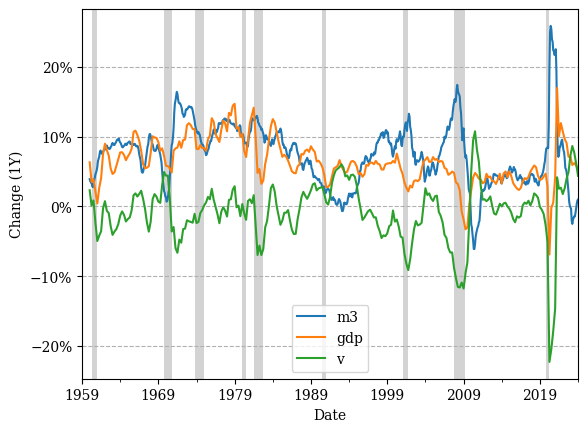

In [224]:
fig, ax = plt.subplots()

df_us[['m3']].pct_change(periods=12, fill_method=None).plot(ax=ax)
df_us[['gdp', 'v']].dropna().pct_change(periods=4, fill_method=None).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');

### Eurozona

Datos: 
- GDP: dos opciones:
    - Gross domestic product at market prices, Euro area 20 (fixed composition) as of 1 January 2023, Quarterly. [ECB](https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N)
    - **Gross domestic product at market prices, Euro area (Member States and Institutions of the Euro Area) changing composition, Quarterly.** [ECB](https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.N.U2.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N)
- M3: Monetary aggregate M3 reported by MFIs, central gov. and post office giro institutions in the euro area (stocks), Euro area (changing composition), Monthly. [ECB](https://data.ecb.europa.eu/data/datasets/BSI/BSI.M.U2.N.V.M30.X.1.U2.2300.Z01.E).
- HICP: HICP - Overall index, Euro area (changing composition), Monthly. [ECB](https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.U2.N.000000.4.INX).

In [225]:
df_eu = pd.DataFrame()
df_eu['m3'] = get_ecb_data('BSI',
                     'M.U2.N.V.M30.X.1.U2.2300.Z01.E') # Monthly data
df_eu['gdp'] = get_ecb_data('MNA',
                      'Q.N.U2.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N') # Quarterly data
                    #   'Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N') # Quarterly data
df_eu['cpi'] = get_ecb_data('ICP',
                     'M.U2.N.000000.4.INX') # Monthly data
# df_eu.dropna(inplace=True) # Remove NaN
df_eu['v'] = df_eu['gdp']/df_eu['m3']

/Users/miguel/Documents/workspace/money-growth/utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(io.StringIO(response.text), parse_dates=[


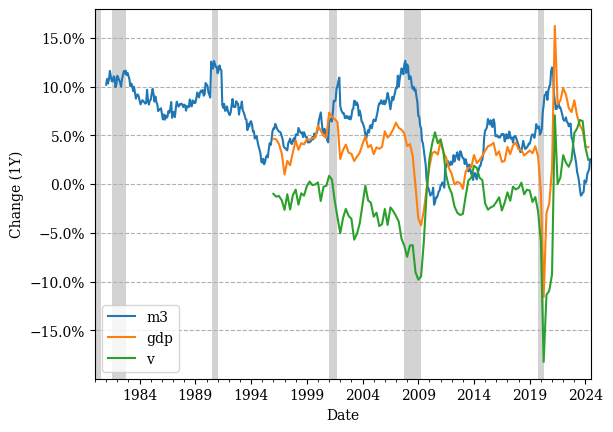

In [226]:
fig, ax = plt.subplots()

df_eu[['m3']].pct_change(periods=12, fill_method=None).plot(ax=ax)
df_eu[['gdp', 'v']].dropna().pct_change(periods=4, fill_method=None).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');

### Suiza

- Inflation according to the national consumer price index: ambas series coinciden exactamente cuando se calcula el porcentaje de cambio.
    - `plkopr{LD2010100}`: National index (Dec. 2020=100) [SNB](https://data.snb.ch/en/topics/uvo/cube/plkopr).
    - `plkoprinfla{TLK}`: Change [SNB](https://data.snb.ch/en/topics/uvo/cube/plkoprinfla).

Otras opciones para inflación: 
- Eurostat HICP - monthly data (index). [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_midx/default/table?lang=en&category=prc.prc_hicp).
- IMF PCPIP: Inflation rate, averge consumer prices. [IMF](https://data.imf.org/?sk=4ffb52b2-3653-409a-b471-d47b46d904b5)

In [227]:
df_ch = pd.DataFrame()

table_id = "snbmonagg"
params = {'dimSel': 'D0(B),D1(GM3)',
          'fromDate': '1980-01',
          }

df_ch['m3'] = get_snb_data(table_id, params)['Value'] # Monthly data

table_id = "gdpap"
params = {'dimSel': 'D0(WMF),D1(BBIPS)',
          'fromDate': '1980-01',
          # 'toDate': '2024-04'
          }
df_ch['gdp'] = get_snb_data(table_id, params)['Value'] # Quarterly data

table_id = 'plkopr'
params = {'dimSel': 'D0(LD2010100)',
          'fromDate': '1980-01',
          }
df_ch['cpi'] = get_snb_data(table_id, params)['Value'] # Monthly data

df_ch['v'] = df_ch['gdp']/df_ch['m3']

/Users/miguel/Documents/workspace/money-growth/utils.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url,


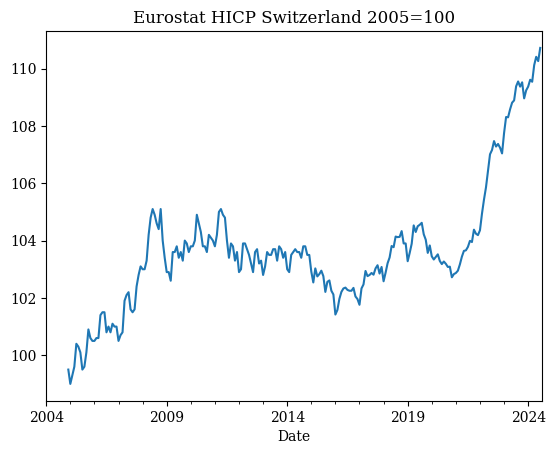

In [228]:
import eurostat

data = eurostat.get_data_df('prc_hicp_midx', filter_pars={'geo': ['CH'], 'unit': ['I05'], 'coicop': ['CP00']})

df = data.melt(id_vars=['freq', 'unit', 'coicop', r'geo\TIME_PERIOD'], var_name='Date', value_name='Value')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')

df.set_index('Date')['Value'].plot(title='Eurostat HICP Switzerland 2005=100', xlim=['2004', None]);

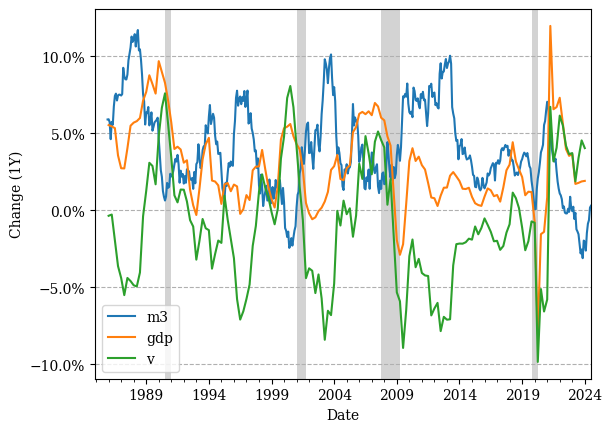

In [229]:
fig, ax = plt.subplots()

df_ch[['m3']].pct_change(periods=12, fill_method=None).plot(ax=ax)
df_ch[['gdp', 'v']].dropna().pct_change(periods=4, fill_method=None).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');

### Reino Unido

- M4x: LPMAUYN, Monthly amounts outstanding of M4 (monetary financial institutions' sterling M4 liabilities to private sector) (in sterling millions) seasonally adjusted [BoE](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=NIxAZxI1x&FromCategoryList=Yes&NewMeaningId=LM4,LM4L&CategId=6&HighlightCatValueDisplay=M4).
- Gross Domestic Product at market prices: Current price: Seasonally adjusted £m, quarterly [ONS](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ybha/pn2).
- Inflation: CPI INDEX 00: ALL ITEMS 2015=100 [ONS](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7bt/mm23).

In [230]:
df_uk = pd.DataFrame()

df_uk['m3'] = get_boe_data('LPMAUYN')
df_uk['cpi'] = pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')
df_uk['gdp'] = pd.read_csv('data/gdp-gb.csv', skiprows=84, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')

df_uk['v'] = df_uk['gdp']/df_uk['m3']

/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_95161/457051752.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_uk['cpi'] = pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')
/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_95161/457051752.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_uk['gdp'] = pd.read_csv('data/gdp-gb.csv', skiprows=84, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')


/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_95161/4096428838.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date').pct_change(periods=12).plot()


<Axes: xlabel='Date'>

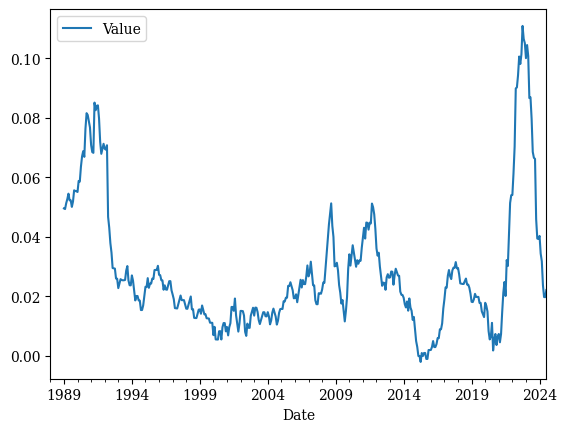

In [231]:
pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date').pct_change(periods=12).plot()

### Japón

Datos:
- M3: MD02'MAM1NAM3M3MO: M3/Average Amounts Outstanding/Money Stock [BoJ Time-Series Data Search](https://www.stat-search.boj.or.jp/ssi/mtshtml/md02_m_1_en.html).
- CPI: 
    - e-Stat: [2020-Base Consumer Price Index. Monthly Report. 2024Jul.](https://www.e-stat.go.jp/en/stat-search/files?page=1&layout=datalist&toukei=00200573&tstat=000001150147&cycle=1&year=20240&month=23070907&tclass1=000001150149&result_back=1&tclass2val=0)
    - Bank of Japan: [Measures of Underlying Inflation](https://www.boj.or.jp/en/research/research_data/cpi/index.htm).

Referencia sobre agregados monetarios: [Monetary Aggregates (market volume, outstanding)](https://www.boj.or.jp/en/statistics/outline/note/notest31.htm).

In [232]:
df_jp = pd.DataFrame()
# df_jp['cpi'] = pd.read_csv('data/cpi-jp.csv',
#                            parse_dates=['Date'],
#                            index_col='Date')[r'Trimmed mean (y/y % chg.)'] # Monthly data
df_jp['cpi'] = pd.read_csv('data/jp-cpi-e-stat.csv',
                           parse_dates=['Date'],
                           index_col='Date')[r'CPI (2020=100)'] # Monthly data
df_jp['m3'] = pd.read_csv('data/m3-jp.csv',
                          skiprows=3,
                          names=['Date', 'Value'],
                          parse_dates=['Date'],
                          date_format={'Date': '%Y/%m'},
                          index_col='Date') # Monthly data

df_jp['gdp'] = fred.get_series('JPNNGDP') # Quarterly data

df_jp['v'] = df_jp['gdp']/df_jp['m3']

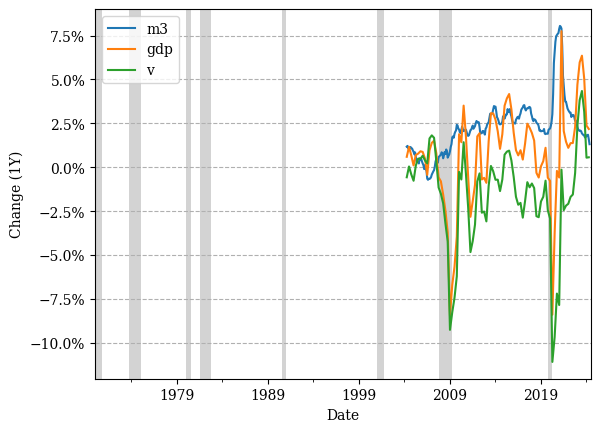

In [233]:
fig, ax = plt.subplots()

df_jp[['m3']].pct_change(periods=12, fill_method=None).plot(ax=ax)
df_jp[['gdp', 'v']].dropna().pct_change(periods=4, fill_method=None).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');

## Exploración de datos

/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_95161/585913513.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_uk['cpi'].pct_change(periods=12).plot(ax=ax, label='UK')


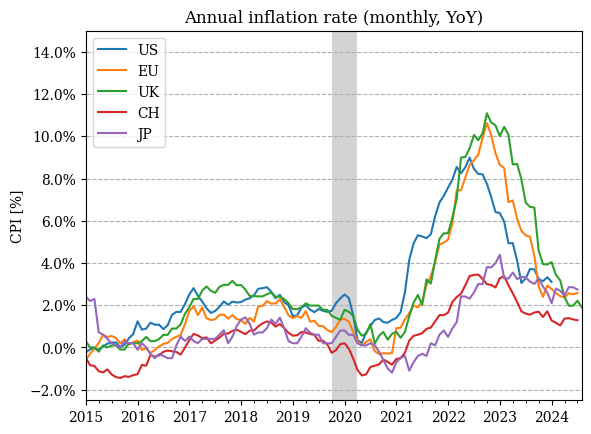

In [234]:
fig, ax = plt.subplots()

df_us['cpi'].pct_change(periods=12).plot(ax=ax, label='US')
df_eu['cpi'].pct_change(periods=12).plot(ax=ax, label='EU')
df_uk['cpi'].pct_change(periods=12).plot(ax=ax, label='UK')
df_ch['cpi'].pct_change(periods=12).plot(ax=ax, label='CH')
df_jp['cpi'].pct_change(periods=12).plot(ax=ax, label='JP')

plot_recessions(ax)

ax.set_xlim(['2015', None])
ax.set_ylim([-.025, .15])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_title('Annual inflation rate (monthly, YoY)')
ax.set_xlabel('')
ax.set_ylabel('CPI [%]')
ax.legend();

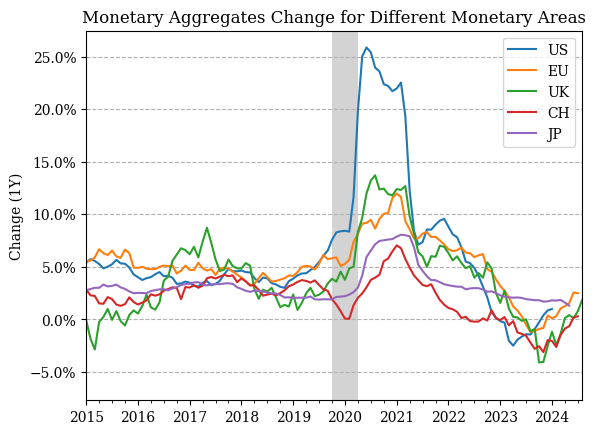

In [235]:
fig, ax = plt.subplots()

df_us['m3'].pct_change(periods=12).plot(ax=ax, label='US')
df_eu['m3'].pct_change(periods=12).plot(ax=ax, label='EU')
df_uk['m3'].pct_change(periods=12).plot(ax=ax, label='UK')
df_ch['m3'].pct_change(periods=12).plot(ax=ax, label='CH')
df_jp['m3'].pct_change(periods=12, fill_method=None).plot(ax=ax, label='JP')
plot_recessions(ax)

ax.set_xlim(['2015', None])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_xlabel('')
ax.set_ylabel('Change (1Y)')
ax.set_title('Monetary Aggregates Change for Different Monetary Areas');
ax.legend();

## Análisis de la velocidad de circulación del dinero

### Contraste de hipótesis

$H_0$: El valor medio de $\Delta\log(v_t)$ es cero.

Se rechaza la hipótesis nula con una significacia mayor al 99%.

Text(0.5, 1.0, 'Estados Unidos')

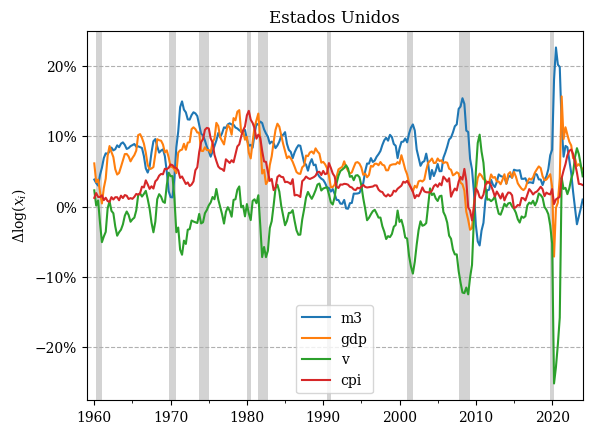

In [236]:
# df_deltaLog = df_ch[['m3', 'gdp', 'v']].dropna().apply(np.log).diff(periods=4)
# df_deltaLog['cpi'] = df_eu['cpi']/100
df_deltaLog = df_us[['m3', 'gdp', 'v', 'cpi']].dropna().apply(np.log).diff(periods=4)
area = 'Estados Unidos'

add_recessions(df_deltaLog)

fig, ax = plt.subplots()
df_deltaLog[['m3', 'gdp', 'v', 'cpi']].plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\log(x_i)$');
ax.set_title(area)

In [237]:
from scipy.stats import t

mu_0 = 0
mean_yi = df_deltaLog['v'].mean()
sm_yi = df_deltaLog['v'].std()
T = df_deltaLog['v'].count()  #  Excluye valores N/A
sm_medias = sm_yi / np.sqrt(T)

t_score = (mean_yi - mu_0) / sm_medias
p_value = 2*t.sf(np.abs(t_score), T-1)
print(f'p-value: {p_value:.5f}')
# Se rechaza H0: mu0=0 al 99%

print(f'mu = {mean_yi*100:.2f}%')
print(
    f"mu = {df_deltaLog.loc[:'2019-12-31', 'v'].mean()*100:.2f}% (hasta 2019.IV)")

print(f'std = {sm_yi*100:.2f}%')
print(
    f"std = {df_deltaLog.loc[:'2019-12-31', 'v'].std()*100:.2f}% (hasta 2019.IV)")

p-value: 0.00174
mu = -0.88%
mu = -0.81% (hasta 2019.IV)
std = 4.48%
std = 3.58% (hasta 2019.IV)


In [238]:
# %% Augmented Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_deltaLog['v'].dropna(), regression='c', autolag='AIC')
print('Augmented Dickey-Fuller')
print(f'\tADF statistic: {result[0]}')
print(f'\tp-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller
	ADF statistic: -3.049072640460463
	p-value: 0.030558879520383154
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


### Autorregresión de Markov

$\Delta\log v_t = \mu_{S_t} + \beta d_\text{recession} + \varepsilon_t$

$\varepsilon_t \sim N(0, \sigma^2)$

$S_t\in \{0,1\}$

$P(S_t=s_t|S_{t-1}=s_{t-1})=
\begin{bmatrix}
  p_{00} & p_{10}\\
  1-p_{00} & 1-p_{10}
\end{bmatrix}$

$p_ij$ es la probabilidad de transicionar desde el régimen $i$ al régimen $j$.

Referencias:
- Reference: https://stackoverflow.com/questions/42796743/python-statsmodel-tsa-markovautoregression-using-current-real-gnp-gdp-data
- Reference: https://nbviewer.org/gist/ChadFulton/a5d24d32ba3b7b2e381e43a232342f1f
- statsmodels: https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_autoregression.MarkovAutoregression.html
- statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html
- statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html
- mswitch (Stata): https://www.stata.com/manuals14/tsmswitch.pdf


Estimated duration: [80.77844366  6.10272022]


/Users/miguel/Documents/workspace/money-growth/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      v   No. Observations:                  257
Model:               MarkovRegression   Log Likelihood                 496.370
Date:                Wed, 11 Sep 2024   AIC                           -980.740
Time:                        23:20:23   BIC                           -959.445
Sample:                    01-01-1960   HQIC                          -972.176
                         - 01-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.654      0.513      -0.003       0.006
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1086      0.011     -9.562      0.000      -0.131      -0.086
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0149      0.007     -2.238      0.025      -0.028      -0.002
sigma2         0.0011   9.67e-05     10.942      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9876      0.007    132.274      0.000       0.973       1.002
p[1->0]        0.1639      0.087      1.887      0.059      -0.006       0.334
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

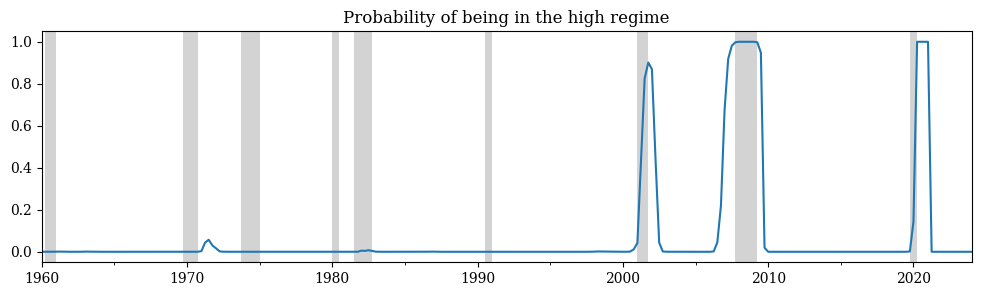

In [239]:
import statsmodels.api as sm

y = df_deltaLog.dropna()['v'].astype(float)
X = df_deltaLog.dropna()['recession'].astype(float)
# X = sm.add_constant(X) # Not to be included if the option trend='c' is specified at MarkovRegression

model = sm.tsa.MarkovRegression(
    y, k_regimes=2,
    exog=X,  
    switching_exog=False,
    # switching_trend=False,
    trend='c'
)
res = model.fit()

fig, ax = plt.subplots(figsize=(12, 3))

res.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", ax=ax
)
plot_recessions(ax)
ax.set_xlabel('')

print(f'Estimated duration: {res.expected_durations}')
res.summary()

# res.trend

R^2 = 0.5147
SST = 0.5141
SSE = 0.2495
SSR = 0.2199


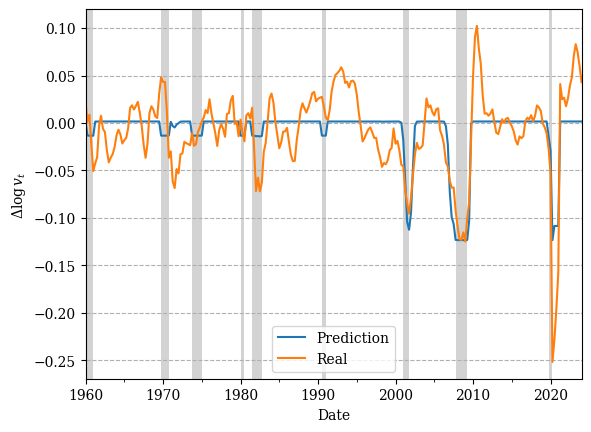

In [240]:
y_hat = res.predict()

fig, ax = plt.subplots()

y_hat.plot(ax=ax, label='Prediction')
y.plot(ax=ax, label='Real')
plot_recessions(ax)

ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel(r'$\Delta\log v_t$');
ax.legend()

y_mean = y.mean()

sst = ((y-y_mean)**2).sum()
sse = ((y-y_hat)**2).sum()
ssr = ((y_hat-y_mean)**2).sum()
r2 = 1-sse/sst

print(f'R^2 = {r2:.4f}')

print(f'SST = {sst:.4f}')
print(f'SSE = {sse:.4f}')
print(f'SSR = {ssr:.4f}')

R^2 = 0.5147


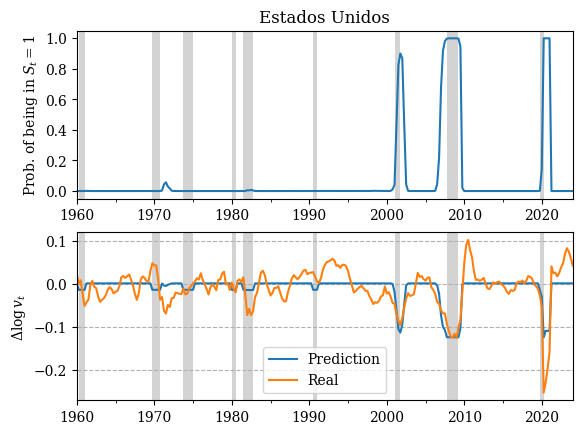

In [241]:
fig, ax =plt.subplots(2)
ax[0].set_title(area)
res.smoothed_marginal_probabilities[1].plot(
    ylabel="Prob. of being in $S_t=1$", ax=ax[0]
)
plot_recessions(ax[0])
ax[0].set_xlabel('')

y_hat.plot(ax=ax[1], label='Prediction')
y.plot(ax=ax[1], label='Real')
plot_recessions(ax[1])

ax[1].grid(which='major', axis='y', linestyle='--')  #  or both
ax[1].set_xlabel('')
ax[1].set_ylabel(r'$\Delta\log v_t$');
ax[1].legend()

print(f'R^2 = {r2:.4f}')

### Inflación

/Users/miguel/Documents/workspace/money-growth/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Estimated duration: [43.4654493   8.61907631]


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    cpi   No. Observations:                  255
Model:               MarkovRegression   Log Likelihood                 735.946
Date:                Wed, 11 Sep 2024   AIC                          -1443.891
Time:                        23:20:24   BIC                          -1394.313
Sample:                    07-01-1960   HQIC                         -1423.949
                         - 01-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.428      0.153      -0.001       0.008
x4             0.1912      0.058      3.289      0.001       0.077       0.305
x5             0.2726      0.152      1.788      0.074      -0.026       0.572
x6             0.1537      0.094      1.632      0.103      -0.031       0.338
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0525      0.010      5.444      0.000       0.034       0.071
x4            -0.4438      0.155     -2.859      0.004      -0.748      -0.140
x5             0.2170      0.238      0.913      0.361      -0.249       0.683
x6             0.2620      0.225      1.166      0.244      -0.178       0.702
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1005      0.060      1.668      0.095      -0.018       0.219
x2            -0.0025      0.111     -0.023      0.982      -0.219       0.214
x3             0.0960      0.075      1.278      0.201      -0.051       0.243
sigma2         0.0001    1.3e-05     11.018      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9770      0.010     95.566      0.000       0.957       0.997
p[1->0]        0.1160      0.053      2.184      0.029       0.012       0.220
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

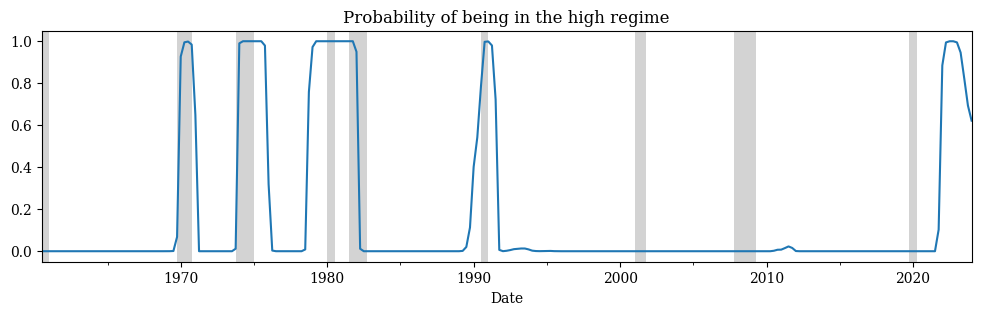

In [242]:
y = df_deltaLog.dropna()['cpi'].astype(float)
X = df_deltaLog.dropna()[['v', 'm3']].astype(float)

max_lags = 2

for i in range(1, max_lags+1):
    X[f'v_lag_{i}'] = X['v'].shift(i)

for i in range(1, max_lags+1):
    X[f'm3_lag_{i}'] = X['m3'].shift(i)

y = y[max_lags:]
X = X.iloc[max_lags:]
# X.drop('v', axis=1, inplace=True)

model = sm.tsa.MarkovRegression(
    y, k_regimes=2,
    exog=X,  
    # switching_exog={'v': False, 'm3': True},
    switching_exog=[False] * (max_lags + 1) + [True] * (max_lags+1),
    # switching_trend=False,
    trend='c'
)
res = model.fit()


fig, ax = plt.subplots(figsize=(12, 3))

res.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", ax=ax
)
plot_recessions(ax)

print(f'Estimated duration: {res.expected_durations}')
res.summary()

# res.trend

R^2 = 0.8191
SST = 0.1825
SSE = 0.0330
SSR = 0.1422


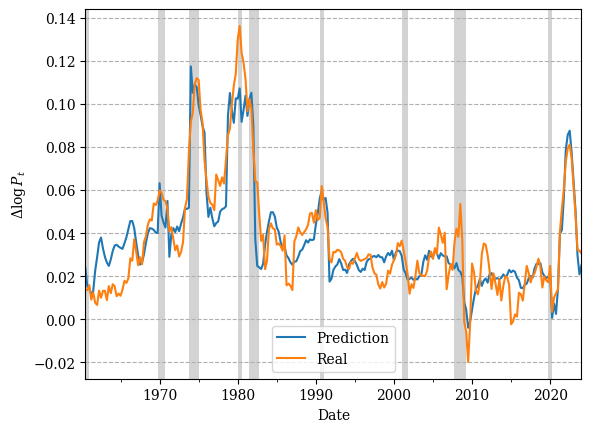

In [243]:
y_hat = res.predict()

fig, ax = plt.subplots()

y_hat.plot(ax=ax, label='Prediction')
y.plot(ax=ax, label='Real')
plot_recessions(ax)

ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel(r'$\Delta\log P_t$');
ax.legend()

# Compute errors
y_mean = y.mean()

sst = ((y-y_mean)**2).sum()
sse = ((y-y_hat)**2).sum()
ssr = ((y_hat-y_mean)**2).sum()
r2 = 1-sse/sst

print(f'R^2 = {r2:.4f}')

print(f'SST = {sst:.4f}')
print(f'SSE = {sse:.4f}')
print(f'SSR = {ssr:.4f}')

R^2 = 0.8191


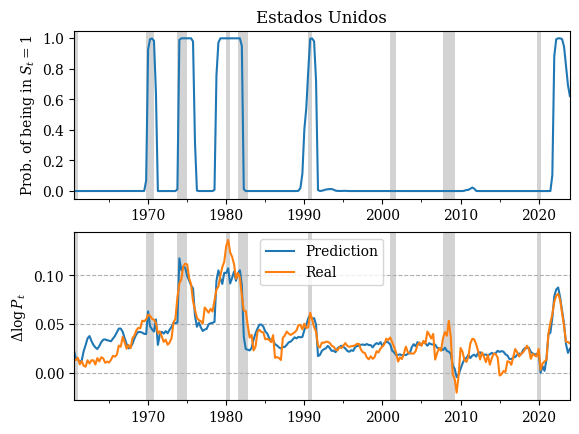

In [244]:
figs, ax =plt.subplots(2)
ax[0].set_title(area)
res.smoothed_marginal_probabilities[1].plot(
    ylabel="Prob. of being in $S_t=1$", ax=ax[0]
)
plot_recessions(ax[0])
ax[0].set_xlabel('')

y_hat.plot(ax=ax[1], label='Prediction')
y.plot(ax=ax[1], label='Real')
plot_recessions(ax[1])

ax[1].grid(which='major', axis='y', linestyle='--')  #  or both
ax[1].set_xlabel('')
ax[1].set_ylabel(r'$\Delta\log P_t$');
ax[1].legend()

print(f'R^2 = {r2:.4f}')